Mickias Ambaye  
Date: 2026-02-18  
Machine Learning  
Data source: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python?select=Mall_Customers.csv


# Mall Customer Segmentation

## 1. Introduction

Customer segmentation helps businesses tailor their marketing by finding groups of customers with different behaviors and needs. In this project, we use unsupervised machine learning on mall membership card data, focusing on Age, Annual Income, and Spending Score to create useful customer groups.

Two methods will be applied: **K-Means** as the primary clustering approach with the optimal number of clusters determined by the **Elbow Method** and validated by the **Silhouette Score**, and **Hierarchical Clustering** as a secondary method to independently confirm the cluster structure via **dendrogram**. Where both methods agree, the segments can be treated as robust and ready for marketing application.

There is no target variable or accuracy score in this project. Instead, we measure success by how easy the segments are to understand and how useful they are for business decisions.

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

In [128]:
df = pd.read_csv("Mall_Customers.csv", index_col=0)

## 2. Exploratory Data Analysis (EDA)

### 2.1 Data Overview

> The dataset is small and clean, with 200 customers and 5 features. There are no missing values, so we do not need to do any imputation. CustomerID has been index when loading data, before clustering because it does not add analytical value. Genre(Gender) is the only categorical variable and will need to be binary encoded. The three numerical features; Age, Annual Income, and Spending Score; are on different scales, so we need to use StandardScaler before any distance-based clustering. We also need to rename some of the columns to be more concise.

In [129]:
# Check shape, dtype and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Genre                   200 non-null    object
 1   Age                     200 non-null    int64 
 2   Annual Income (k$)      200 non-null    int64 
 3   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [130]:
# Check for duplicates
print(f"Found {df.duplicated().sum()} duplicates")

Found 0 duplicates


In [131]:
# rename for simplicity 
df.rename(columns={'Annual Income (k$)': 'Annual_Income', 
                    'Spending Score (1-100)': 'Spending_Score', 
                    'Genre': 'Gender'}, inplace=True)

In [132]:
df.describe()

,Age,Annual_Income,Spending_Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


> **Descriptive Statistics:**
`Age` averages 39 with good spread (18–70), `Income` averages $60k ranging widely up to $137k, and `Spending Score` is nearly perfectly centered at 50 with full range coverage (1–99);  all three features carry genuine variance, confirming they'll be informative for clustering.

### 2.2 Feature Distribution 

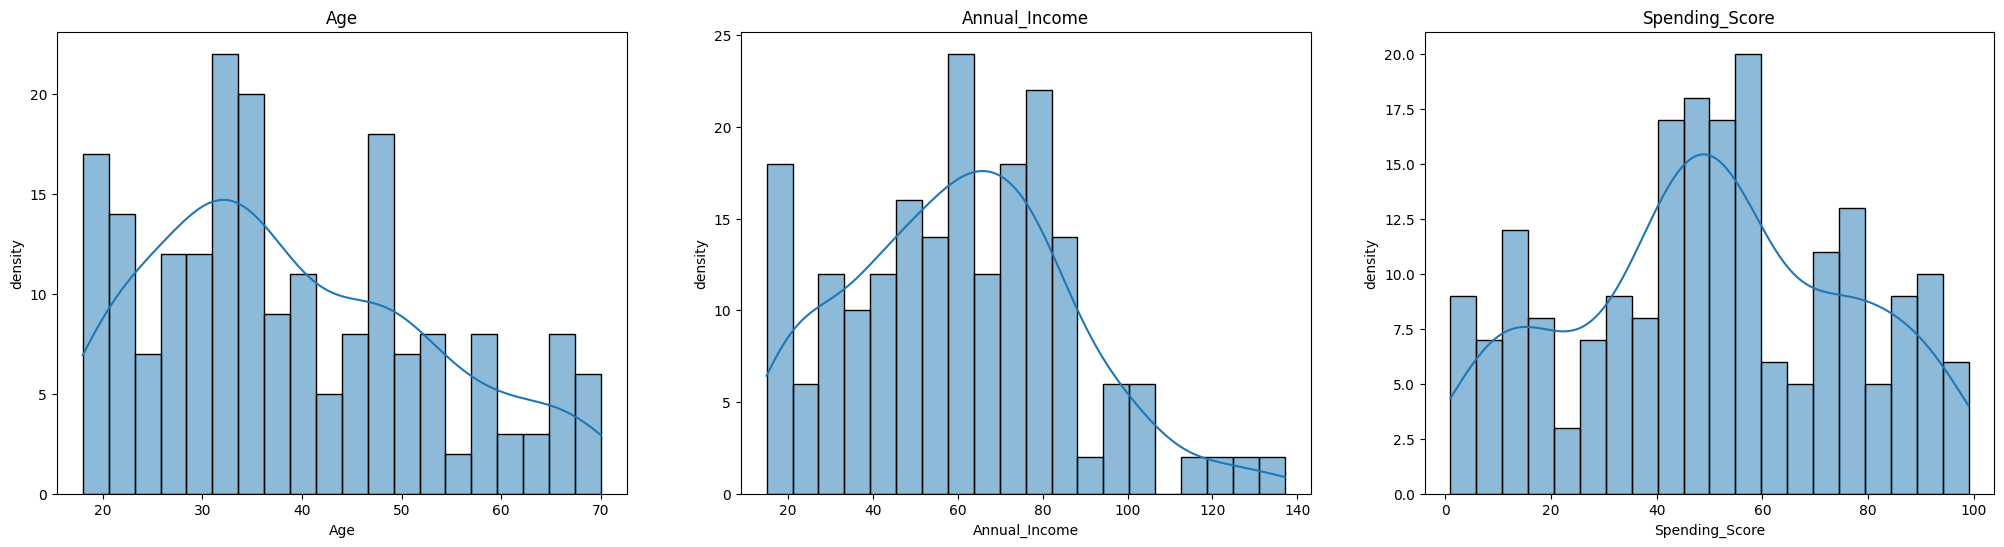

In [133]:
num_cols = [col for col in df.columns if df[col].dtype != 'object']

# Subplots of the numerical columns
plt.figure(figsize=(25, 6))
for i, col in enumerate(num_cols):
    plt.subplot(1, 3, i+1)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('density')
plt.show()

> **Feature Distributions:**`Age` is right-skewed with a young adult concentration around 30. `Income` is roughly normal but with a long right tail — a small high-earner segment is visible. `Spending Score` shows a notable tri-modal tendency, with peaks around 50 and again near 80 and 15 this is an early signal that distinct spending behavior groups exist in the data.

In [134]:
df.Gender.value_counts(normalize=True)

Gender
Female    0.56
Male      0.44
Name: proportion, dtype: float64

> **Gender Split:**
56% Female, 44% Male; reasonably balanced, no dominance concern. Gender alone is unlikely to drive cluster separation but may help profile clusters after the fact.

### 2.3 Bivariate Analysis
Income vs spending score | Age vs spending score 

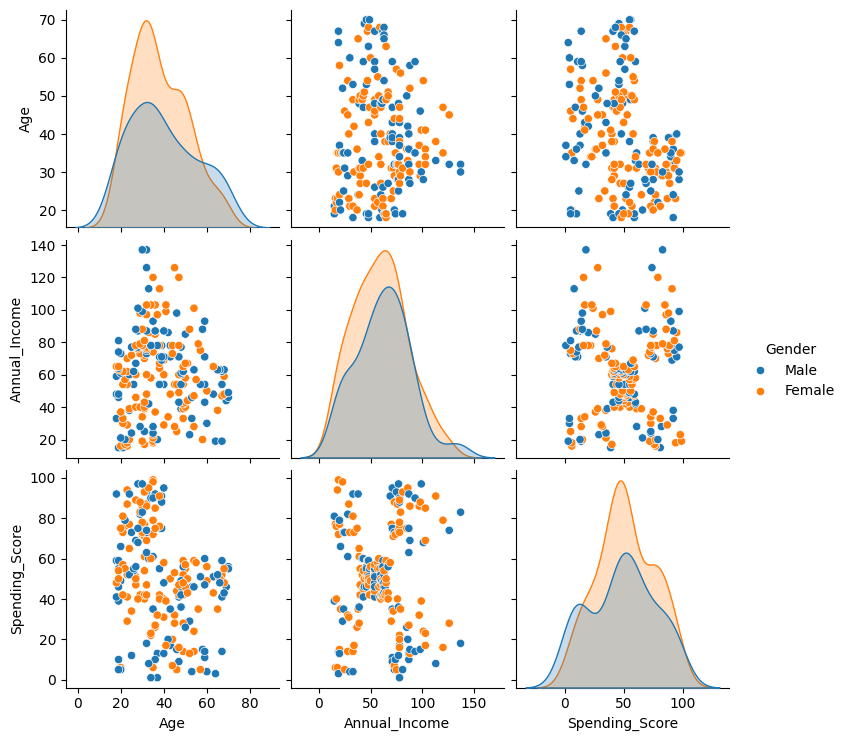

In [135]:
sns.pairplot(df, hue='Gender')

> **Pairplot:**
The Income vs Spending Score panel stands out. There is a clear visual suggestion of four or five distinct clusters: low income/low spend, low income/high spend, high income/low spend, high income/high spend, and a middle group. The Age vs Spending Score panel shows a weaker but still noticeable pattern, with younger customers tending to have higher spending scores. Gender does not seem to separate the data in any panel, which suggests it works better as a profiling variable than as a clustering feature.

### 2.4 Correlation Analysis

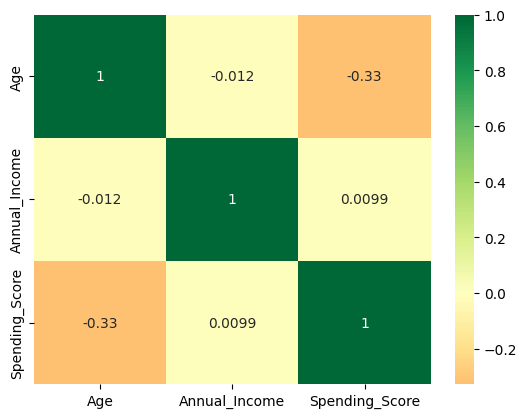

In [136]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='RdYlGn', center=0)
plt.show()

> `Age` and `Spending Score` have the only meaningful relationship (-0.33);  older customers tend to spend less. Income is essentially independent of both, which is actually useful as it means all three features bring distinct information to the clustering.

## 3. Data Preprocessing

### 3.1 Encoding Gender

> Gender is only useful here as a profiling variable after clustering (e.g., describing what percent of a cluster is female), not as a clustering feature itself since the pairplot showed it doesn't drive separation. So there is no point in encoding it.

In [137]:
# # Encoding Gender using map function
# df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})

### 3.2 Feature Scaling

In [138]:
features = ['Annual_Income', 'Spending_Score']

scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

## 4. K-Means Clustering

In [139]:
# Define features for clustering
x = df[features]
K = range(2, 11)

### 4.1 Elbow Method

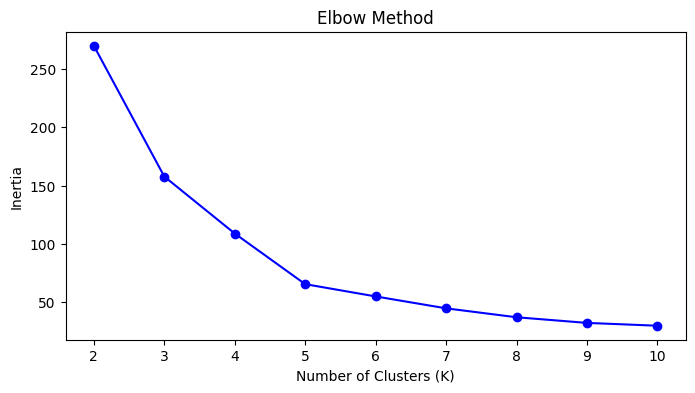

In [140]:
# Elbow Method 
inertia = []
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(x)
    inertia.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

> Elbow Method: No sharp elbow — inertia drops steeply to K=5 then flattens, suggesting 5+ clusters but not pinpointing an exact number. Rely on Silhouette to decide.

### 4.2 Silhouette Score

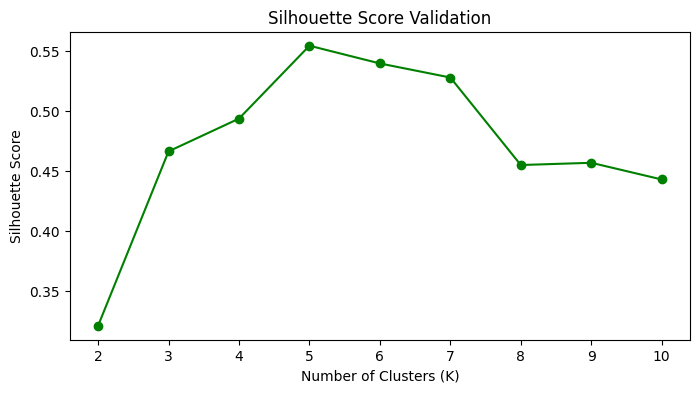

In [141]:
# Shilhoutte Score
sil_scores = []
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(x)
    sil_scores.append(silhouette_score(x, labels))

plt.figure(figsize=(8, 4))
plt.plot(K, sil_scores, 'go-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Validation')
plt.show()

> **Silhouette Score:** Clear peak at K=5, validating the elbow method choice for optimal clusters. 

### 4.3 Optimal K

> Since both the elbow method and Silhouette Score suggest 5 clusters, we'll proceed with K=5.

In [142]:
optimal_k = 5  # adjust after reviewing Silhouette plot above 
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df['KMeans_Cluster'] = kmeans.fit_predict(x)

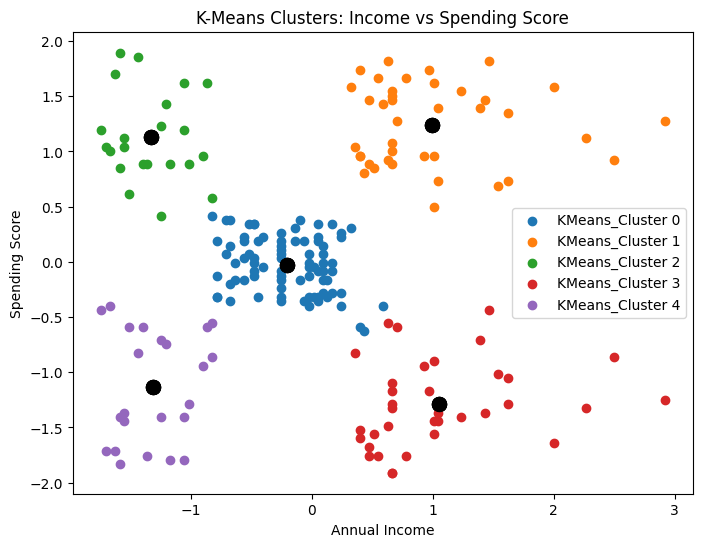

In [149]:
# Visualize clusters for optimal K
plt.figure(figsize=(8, 6))
for cluster in range(optimal_k):
    subset = df[df['KMeans_Cluster'] == cluster]
    plt.scatter(subset['Annual_Income'], subset['Spending_Score'], label=f'KMeans_Cluster {cluster}')
    # Centroids
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c='black')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.title('K-Means Clusters: Income vs Spending Score')
plt.legend()
plt.show()

## 5. Hierarchical Clustering

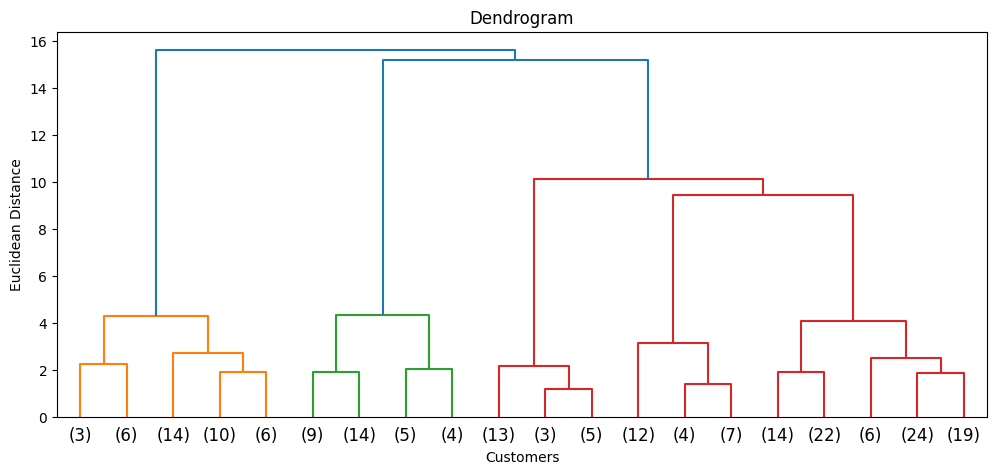

In [153]:
# --- Dendrogram ---
linked = linkage(x, method='ward')
plt.figure(figsize=(12, 5))
dendrogram(linked, truncate_mode='lastp', p=20)
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()

> **Dendrogram:** Suggests 3 main groups at the highest distance cut (~14), but cutting lower at distance ~8 reveals 5 clean clusters; consistent with K-Means. Go with 5 for HC to match.

In [160]:
hc = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
df['HC_Cluster'] = hc.fit_predict(x)

In [161]:
# --- Adjusted Rand Index ---
from sklearn.metrics import adjusted_rand_score
ari = adjusted_rand_score(df['KMeans_Cluster'], df['HC_Cluster'])
print(f"Adjusted Rand Index (KMeans vs HC): {ari:.4f}")

Adjusted Rand Index (KMeans vs HC): 0.9420


> **ARI of 0.9420 is strong** both methods are largely agreeing on cluster assignments, which validates that the 5-segment structure is real and not an artifact of either algorithm.

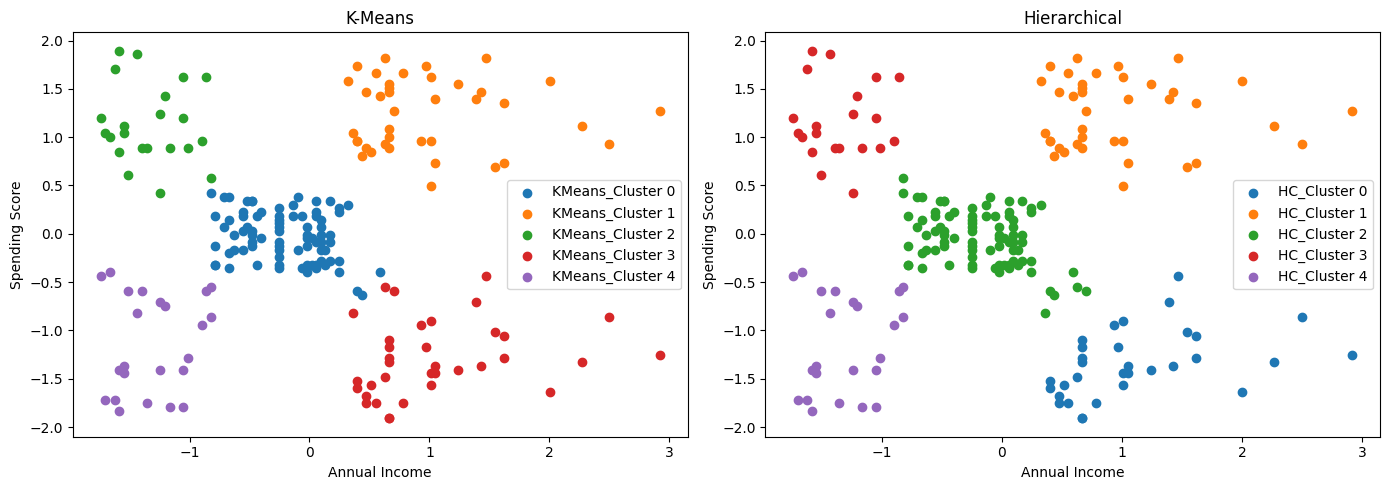

In [162]:
# --- Visual Comparison ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, col, title in zip(axes, ['KMeans_Cluster', 'HC_Cluster'], ['K-Means', 'Hierarchical']):
    for c in sorted(df[col].unique()):
        sub = df[df[col] == c]
        ax.scatter(sub['Annual_Income'], sub['Spending_Score'], label=f'{col} {c}')
    ax.set_title(title)
    ax.set_xlabel('Annual Income')
    ax.set_ylabel('Spending Score')
    ax.legend()
plt.tight_layout()
plt.show()

## 6. Cluster Profiling & Business Insights

In [163]:
# Cluster Profiling
profile = df.groupby('KMeans_Cluster')[['Age', 'Annual_Income', 'Spending_Score']].mean().round(2)
profile['Count'] = df['KMeans_Cluster'].value_counts().sort_index()
profile['% Female'] = df.groupby('KMeans_Cluster')['Gender'].apply(lambda x: (x == 'Female').mean()).round(2)
print(profile)

                  Age  Annual_Income  Spending_Score  Count  % Female
KMeans_Cluster                                                       
0               42.72          -0.20           -0.03     81      0.59
1               32.69           0.99            1.24     39      0.54
2               25.27          -1.33            1.13     22      0.59
3               41.11           1.06           -1.28     35      0.46
4               45.22          -1.31           -1.14     23      0.61


In [ ]:
# # Segment names mapping - not needed for the analysis
# segment_names = {
#     0: 'Average',
#     1: 'High Income High Spend',
#     2: 'Low Income High Spend', 
#     3: 'High Income Low Spend',
#     4: 'Low Income Low Spend'
# }
# df['Segment'] = df['KMeans_Cluster'].map(segment_names)

### **Cluster Profiles & Marketing Recommendations:**

> **Average (Cluster 0 – 81 customers, Age 43, 59% Female):** This is the largest group, with middle income and average spending. They respond well to seasonal promotions, loyalty programs, and bundle deals. They require little effort and provide steady returns.

> **High Income High Spend (Cluster 1 – 39 customers, Age 33, 54% Female):** These are prime customers who are young, earn a lot, and already spend freely. Focus on VIP experiences, early access to new stores, and premium loyalty rewards to keep them coming back.

> **Low Income High Spend (Cluster 2 – 22 customers, Age 25, 59% Female):** This is the youngest group, spending much more than their income suggests. Target them with affordable premium options, installment plans, and trendy products. Monitor closely, as too much targeting could cause financial strain.

> **High Income Low Spend (Cluster 3 – 35 customers, Age 41, 46% Female):** This group is the top priority for conversion. They earn well but do not spend much and are mostly male. Use quality-focused campaigns, personalized outreach, and premium brand showcases to change their perception.

> **Low Income Low Spend (Cluster 4 – 23 customers, Age 45, 61% Female):** This group is budget-conscious and has low potential for conversion. Use discount events and value promotions only. Keep marketing spend low for this segment.



## 7. **Conclusion**

> Both K-Means and Hierarchical Clustering produced the same five customer segments, with an ARI of 0.942. This shows the segmentation is reliable and not tied to a specific algorithm. Income and Spending Score are the main ways the groups differ, while Age and Gender helps profile them, especially since the high-spending segments are much younger. The main business insight is that Cluster 3 (High Income, Low Spend) is the biggest untapped revenue opportunity. This group includes 35 customers who have the means to spend but are not converting, and it is also the most male-dominated segment. This suggests the mall’s current offerings may not appeal to these customers. Cluster 1 should be retained through targeted investment, and Cluster 2 needs careful engagement because their spending does not match their income. The Average segment is the largest, but marketing efforts should be balanced. Investing more in conversion and retention will likely give a better return per dollar spent.